U.S. Inflation: The Price We Pay for Change 💰🔥

Inflation is the silent force that makes your coffee cost more each year. It measures how prices rise over time, affecting everything from groceries to rent. Too high? It erodes your paycheck. Too low? The economy slows down. Policymakers, investors, and everyday consumers keep a close eye on it because inflation shapes interest rates, wages, and financial markets.

Your dataset? A snapshot of history—telling the story of how prices moved across decades.
The dataset contains monthly U.S. inflation rate(over 40 years starting from 1950) data from a source named Mishkin (possibly referencing economist Frederic Mishkin, who has worked on inflation and monetary policy).
https://github.com/lachlandeer/hayashir/blob/master/data-raw/mishkin.csv

# 📌 End-To-End Steps for U.S. Inflation Forecasting
1️⃣ Load & Explore Data – Import the U.S. inflation dataset, preprocess, and visualize trends.

2️⃣ Train-Test Split – Properly split the time series (no shuffling!).

3️⃣ Analyze – Examine time series patterns 

4️⃣ Achieve Stationarity – Apply differencing and conduct the ADF test.

5️⃣ Baseline Models – Compare against simple models (historical mean & last-value predictions).

6️⃣ Fit MA Model –

- Select lag order and train an MA(q) model.
- Obtain model summary & diagnostics 📊
7️⃣ Evaluate Performance –

- Use dynamic forecasting on test data.
- Perform inverse differencing to revert transformations.
- Compare accuracy using MAE & other metrics.
8️⃣ Forecast Future Data –

- Generate dynamic forecasts 📈
- Perform inverse differencing to restore scale.
- Predict inflation for the next 24 months 🔮
hquake trends.

# 🔹 Step 1: Import Libraries & Load Data

In [201]:

# Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.tsa.stattools import adfuller


In [202]:

# Load dataset

df = pd.read_csv('data/usinflation.csv')



# Display first few rows
df.head()

,year,month,inflation_1
0,1950,2,-3.552289
1,1950,3,5.247540
2,1950,4,1.692860
3,1950,5,5.064298
4,1950,6,6.719322


In [203]:
# Combine 'year' and 'month' to create a datetime column
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))

# Set the datetime column as the index
df.set_index('date', inplace=True)
# Drop 'year' and 'month' columns from the DataFrame
df.drop(columns=['year', 'month'], inplace=True)

# Display the updated DataFrame
df.head()

,inflation_1
date,
1950-02-01,-3.552289
1950-03-01,5.247540
1950-04-01,1.692860
1950-05-01,5.064298
1950-06-01,6.719322


In [204]:
df.isna().sum()

inflation_1    0
dtype: int64

In [205]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 491 entries, 1950-02-01 to 1990-12-01
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   inflation_1  491 non-null    float64
dtypes: float64(1)
memory usage: 7.7 KB


# 🔹 Step 2: Data Analysis And Visualization

## 📌 Plot the US Inflation  Data

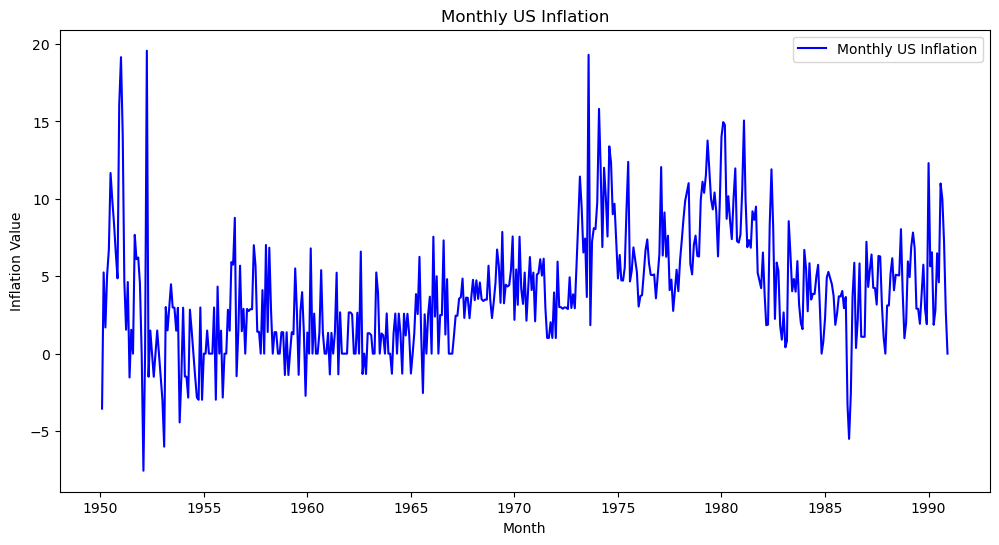

In [206]:
plt.figure(figsize=(12,6))
plt.plot(df, label="Monthly US Inflation", color='blue')
plt.title("Monthly US Inflation")
plt.xlabel("Month")
plt.ylabel("Inflation Value")
plt.legend()
plt.show()

## Check for Stationarity (Dickey-Fuller Test)

## Rolling Statistics

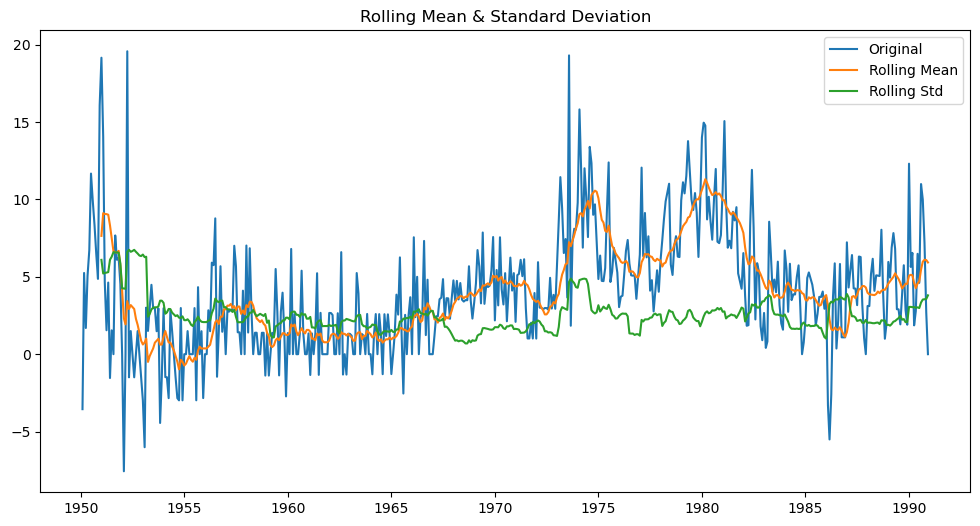

In [207]:
plt.figure(figsize=(12,6))

#Determing rolling statistics
rolmean = df.rolling(window=12).mean()
rolstd = df.rolling(window=12).std()

#Plot rolling statistics:
orig = plt.plot(df, label='Original')
mean = plt.plot(rolmean, label='Rolling Mean')
std = plt.plot(rolstd, label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

### ADF Test

In [208]:
# ADF Test
def adf_test(series, alpha=0.05):
    """
    Performs the Augmented Dickey-Fuller (ADF) test on a time series.

    Parameters:
    - series (pd.Series): The time series data to test.
    - alpha (float): Significance level (default is 0.05).

    Returns:
    - None (prints the results)
    """
    result = adfuller(series, autolag='AIC')

    # Create results dictionary
    output = {
        'Test Statistic': result[0],
        'p-value': result[1],
        '# Lags Used': result[2],
        'Number of Observations': result[3],
    }

    # Add critical values
    for key, value in result[4].items():
        output[f'Critical Value ({key})'] = value

    # Convert to DataFrame for better readability
    output_df = pd.DataFrame(output.items(), columns=['Metric', 'Value'])

    # Print the results
    print("\n🔍 Results of Augmented Dickey-Fuller Test:")
    print(output_df.to_string(index=False))

    # Interpretation
    print("\n📌 Interpretation:")
    if result[1] <= alpha:
        print(f"✅ The time series is **stationary** (p-value = {result[1]:.5f} ≤ {alpha})")
    else:
        print(f"❌ The time series is **not stationary** (p-value = {result[1]:.5f} > {alpha})")

In [209]:
adf_test(df['inflation_1'])


🔍 Results of Augmented Dickey-Fuller Test:
                Metric      Value
        Test Statistic  -2.489327
               p-value   0.118093
           # Lags Used  18.000000
Number of Observations 472.000000
   Critical Value (1%)  -3.444281
   Critical Value (5%)  -2.867683
  Critical Value (10%)  -2.570042

📌 Interpretation:
❌ The time series is **not stationary** (p-value = 0.11809 > 0.05)


📌 Interpretation:
✅ The time series is **non- stationary** (p-value = 0.11809279841865472 >= 0.05)

# 🔹 Step 3: Train-Test Split

In [210]:

train_size = int(len(df) * 0.9)  # 90% training, 10% testing
train, test = df.iloc[:train_size], df.iloc[train_size:]

print(f"Training Size: {len(train)} months")
print(f"Test Size: {len(test)} months")

Training Size: 441 months
Test Size: 50 months


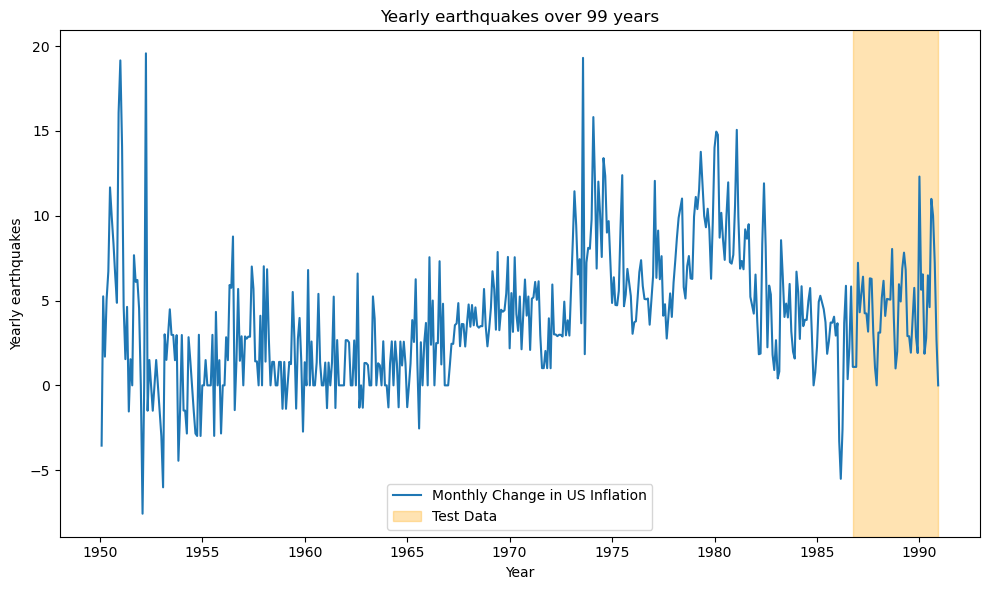

In [211]:
# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['inflation_1'], label='Monthly Change in US Inflation')

# Highlight the period corresponding to the test data
plt.axvspan(train.index[-1], df.index[-1], color='orange', alpha=0.3, label='Test Data')

# Add labels, title, and show legend
plt.xlabel('Year')
plt.ylabel('Yearly earthquakes')
plt.title('Yearly earthquakes over 99 years')
plt.legend()

plt.tight_layout()
plt.show()

# 🔹 Step 4:Create Baseline Models - Historic Mean, Last Value

## Historic Mean

In [212]:
historical_mean=np.mean(train['inflation_1'])

In [213]:
test = test.copy() 
test.loc[:, 'pred_mean'] = historical_mean
test

,inflation_1,pred_mean
date,,
1986-11-01,1.088720,3.93561
1986-12-01,1.087844,3.93561
1987-01-01,7.226761,3.93561
1987-02-01,4.308729,3.93561
1987-03-01,5.364409,3.93561
1987-04-01,6.405601,3.93561
1987-05-01,4.251591,3.93561
1987-06-01,4.236581,3.93561
1987-07-01,3.167622,3.93561


## Create Last Known Value


In [214]:
last = train['inflation_1'].iloc[-1]
last

1.089709

In [215]:
test.loc[:, 'pred_last'] = last
test

,inflation_1,pred_mean,pred_last
date,,,
1986-11-01,1.088720,3.93561,1.089709
1986-12-01,1.087844,3.93561,1.089709
1987-01-01,7.226761,3.93561,1.089709
1987-02-01,4.308729,3.93561,1.089709
1987-03-01,5.364409,3.93561,1.089709
1987-04-01,6.405601,3.93561,1.089709
1987-05-01,4.251591,3.93561,1.089709
1987-06-01,4.236581,3.93561,1.089709
1987-07-01,3.167622,3.93561,1.089709


In [216]:
# Calculate MAE for pred_mean
mae_mean = mean_absolute_error(test["inflation_1"], test["pred_mean"])

# Calculate MAE for pred_last
mae_last = mean_absolute_error(test["inflation_1"], test["pred_last"])

# Print results
print(f"MAE for pred_mean: {mae_mean:.3f}")
print(f"MAE for pred_last: {mae_last:.3f}")

MAE for pred_mean: 2.145
MAE for pred_last: 3.632


# 🔹 Step 5:Create MA Model

## Elimination of Non Stationarity

In [217]:

# create a differenced series
def trend_difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return np.array(diff)


In [218]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

In [219]:
# Apply differencing on just one column, assuming 'inflation' is the column of interest
differenced_series = trend_difference(df['inflation_1'].values, interval=1)

In [220]:


# Convert to DataFrame
df_diff = pd.DataFrame({'inflation_diff': differenced_series})

# Show the first few rows
print(df_diff.head())

   inflation_diff
0        8.799829
1       -3.554680
2        3.371438
3        1.655024
4        4.949598


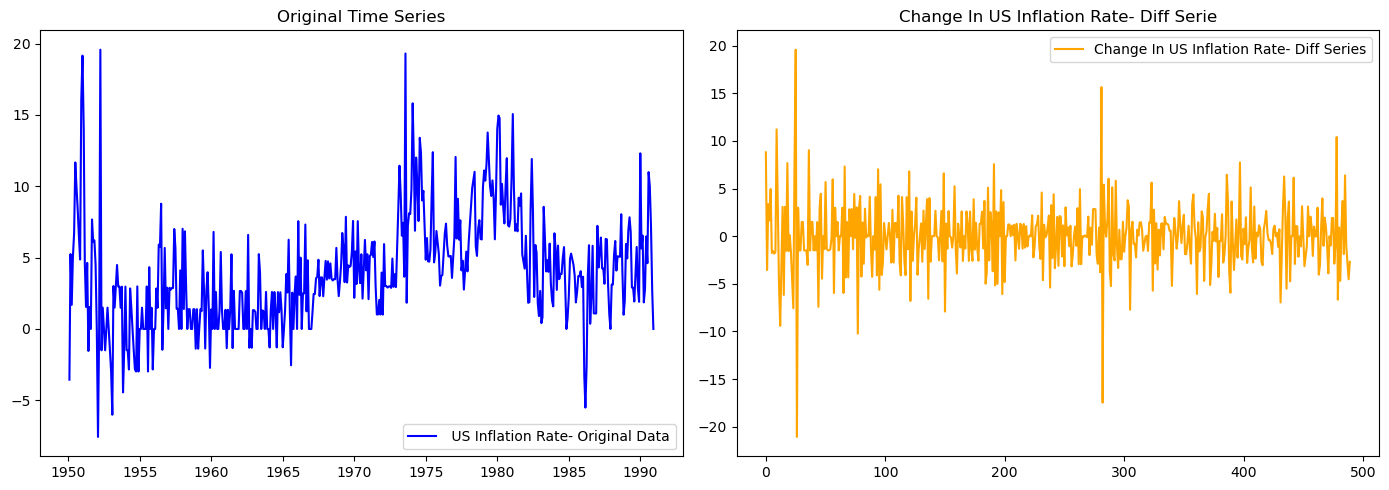

In [221]:
# plot before and after series
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Original series
axes[0].plot(df, label=' US Inflation Rate- Original Data', color='blue')
axes[0].set_title('Original Time Series')
axes[0].legend()

# Diff transformed series
axes[1].plot(df_diff, label="Change In US Inflation Rate- Diff Series", color='orange')
axes[1].set_title('Change In US Inflation Rate- Diff Serie')
axes[1].legend()

plt.tight_layout()
plt.show()

In [222]:
adf_test(df_diff, alpha=0.05)


🔍 Results of Augmented Dickey-Fuller Test:
                Metric         Value
        Test Statistic -5.946907e+00
               p-value  2.193241e-07
           # Lags Used  1.800000e+01
Number of Observations  4.710000e+02
   Critical Value (1%) -3.444310e+00
   Critical Value (5%) -2.867696e+00
  Critical Value (10%) -2.570049e+00

📌 Interpretation:
✅ The time series is **stationary** (p-value = 0.00000 ≤ 0.05)


## Determine Lag Order (q)

## ACF and PACF Plots


In [223]:
# ACF and PACF function to plot both Autocorrelation and Partial Autocorrelation
def ACF_and_PACF(data):
    # Create a figure with a specific size (12x9 inches)
    fig = plt.figure(figsize=(12,9))

    # Add subplot for ACF (Autocorrelation Function)
    ax1 = fig.add_subplot(211)  # The '211' means 2 rows, 1 column, and 1st subplot.
    fig = plot_acf(data, lags=40, ax=ax1)  # Plot the ACF with 40 lags (number of time lags to display).

    # Add subplot for PACF (Partial Autocorrelation Function)
    ax2 = fig.add_subplot(212)  # The '212' means 2 rows, 1 column, and 2nd subplot.
    fig = plot_pacf(data, lags=30, ax=ax2)  # Plot the PACF with 40 lags (number of time lags to display).



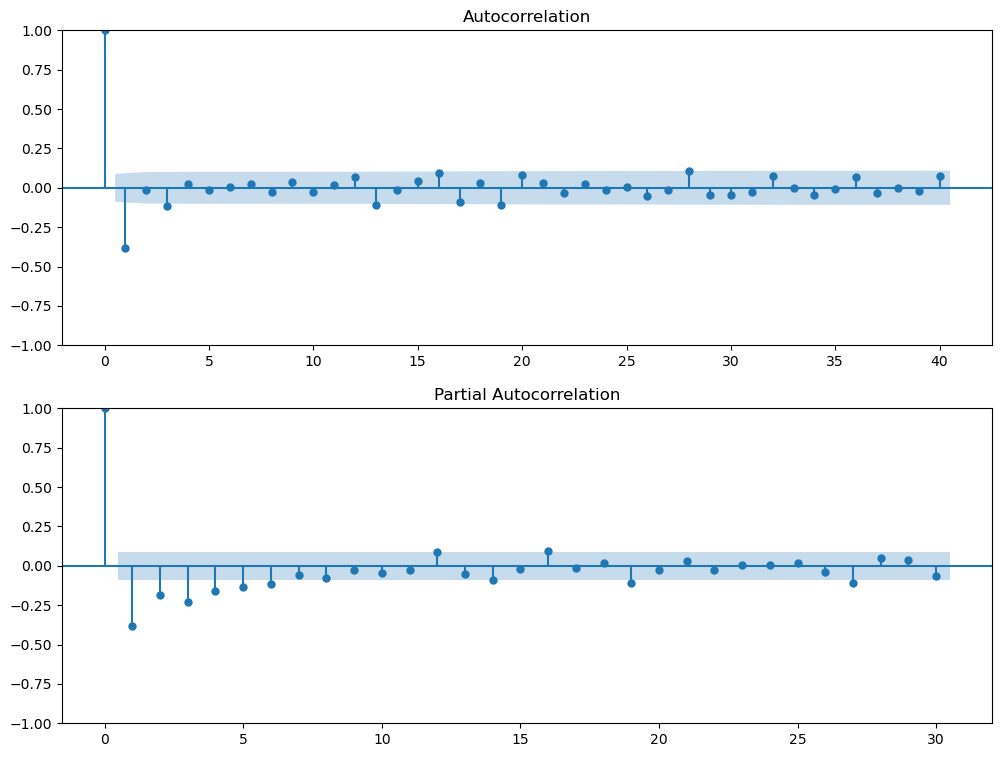

In [224]:
# Call the ACF_and_PACF function for the transformed train data
ACF_and_PACF(df_diff)

In [225]:
# from tqdm import tqdm
# import pandas as pd
# from itertools import product
# from statsmodels.tsa.arima.model import ARIMA

# def optimize_arima(endog, order_list, d):
#     results = []
    
#     for order in tqdm(order_list, desc="Optimizing ARIMA models"):
#         try:
#             # Fit ARIMA model
#             model = ARIMA(
#                 endog, 
#                 order=(order[0], d, order[1])
#             ).fit()
#         except Exception as e:
#             print(f"Model {order} failed with error: {e}")
#             continue
        
#         # Collect AIC for the model
#         aic = model.aic
#         results.append([order, aic])
        
#     # If no valid models were found
#     if not results:
#         print("No valid models were found.")
#         return pd.DataFrame()
    
#     # Create a DataFrame with results
#     result_df = pd.DataFrame(results, columns=['(p, q)', 'AIC'])
    
#     # Sort in ascending order based on AIC
#     result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
#     return result_df


In [226]:
# from itertools import product

# p_range = range(0, 4, 1)
# q_range = range(0, 4, 1)
# d = 0

# myorder_list = list(product(p_range, q_range))

In [227]:
# # Ensure the function name is correct
# result_df = optimize_arima(df_diff, myorder_list, d)
# result_df

## Split Differenced Series - Change in US Inflation

In [228]:
train_diff = df_diff[:int(0.9*len(df_diff))]
test_diff = df_diff[int(0.9*len(df_diff)):]

print(len(train_diff))
print(len(test_diff))

441
49


In [229]:
train_diff.head()

,inflation_diff
0,8.799829
1,-3.554680
2,3.371438
3,1.655024
4,4.949598


# 🔹 Step 5: Train AR Model

In [230]:
# Fit MA model
q = 3
model_fit = ARIMA(train_diff, order=(0,0,3)).fit()

import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")



In [231]:
# Print model summary
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:         inflation_diff   No. Observations:                  441
Model:                 ARIMA(0, 0, 3)   Log Likelihood               -1102.216
Date:                Sat, 15 Feb 2025   AIC                           2214.433
Time:                        08:07:18   BIC                           2234.878
Sample:                             0   HQIC                          2222.498
                                - 441                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0068      0.026     -0.261      0.794      -0.058       0.044
ma.L1         -0.6443      0.030    -21.223      0.000      -0.704      -0.585
ma.L2         -0.0928      0.047     -1.985      0.0

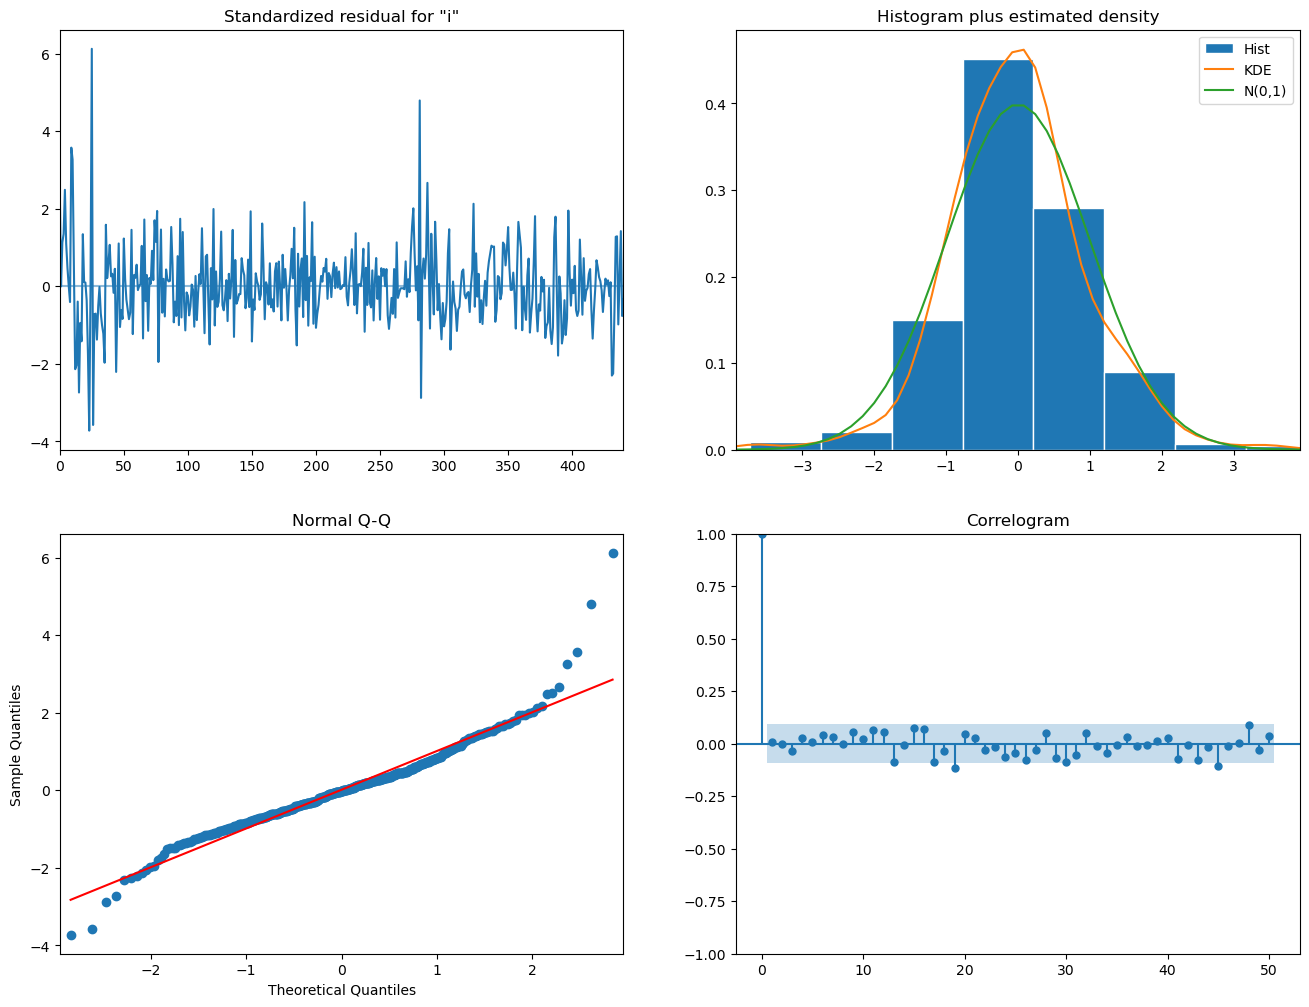

In [232]:
model_fit.plot_diagnostics(lags=50, figsize=(16,12))
plt.show()

# 🔹 Step 6: Model Evaluation
.



## 🔹 (A) Evaluate Model on Train Data(In sample data)


## 📌 One-Step-Ahead Forecast

## 🔹  Evaluate Model on Test Data

In [233]:
# start_index = len(train_diff)
# end_index = len(train_diff)
# forecast = model_fit.predict(start=start_index, end=end_index)

forecast_test = model_fit.get_prediction(start=len(train), end=len(train)+len(test)-1,dynamic=False)


In [234]:
forecast_mean_test=forecast_test.predicted_mean.to_frame()

# Manually assign test index
forecast_mean_test.index = test.index  # Ensure it matches the test set
forecast_mean_test

,predicted_mean
date,
1986-11-01,0.433994
1986-12-01,0.304518
1987-01-01,0.089710
1987-02-01,-0.006766
1987-03-01,-0.006766
1987-04-01,-0.006766
1987-05-01,-0.006766
1987-06-01,-0.006766
1987-07-01,-0.006766


In [235]:
# forecast_mean_test.info()

In [236]:
# test

### Inverse Differencing

In [237]:
# train_diff

In [238]:
print(f"Length of forecast: {len(forecast_mean_test)}")
print(f"Length of test data: {len(test)}")

Length of forecast: 50
Length of test data: 50


In [247]:
# invert the differenced forecast


# Initialize an empty list to store the inverted forecasted values

inverted_forecasts = []
history = [x for x in train['inflation_1']]

# Loop over forecasted values and invert them
for yhat in forecast_mean_test['predicted_mean']:
    inverted = inverse_difference(history, yhat, 1)
    inverted_forecasts.append(inverted)
    history.append(inverted)


# print(f"Length of inverted_forecasts: {len(inverted_forecasts)}")
# print(f"Length of test index: {len(test.index)}")

# Convert to Pandas Series and align index with test data
inverted_forecasts = pd.Series(inverted_forecasts, index=test.index)


inverted_forecasts
   

date
1986-11-01    1.523703
1986-12-01    1.828220
1987-01-01    1.917931
1987-02-01    1.911165
1987-03-01    1.904399
1987-04-01    1.897634
1987-05-01    1.890868
1987-06-01    1.884102
1987-07-01    1.877337
1987-08-01    1.870571
1987-09-01    1.863806
1987-10-01    1.857040
1987-11-01    1.850274
1987-12-01    1.843509
1988-01-01    1.836743
1988-02-01    1.829977
1988-03-01    1.823212
1988-04-01    1.816446
1988-05-01    1.809681
1988-06-01    1.802915
1988-07-01    1.796149
1988-08-01    1.789384
1988-09-01    1.782618
1988-10-01    1.775853
1988-11-01    1.769087
1988-12-01    1.762321
1989-01-01    1.755556
1989-02-01    1.748790
1989-03-01    1.742024
1989-04-01    1.735259
1989-05-01    1.728493
1989-06-01    1.721728
1989-07-01    1.714962
1989-08-01    1.708196
1989-09-01    1.701431
1989-10-01    1.694665
1989-11-01    1.687899
1989-12-01    1.681134
1990-01-01    1.674368
1990-02-01    1.667603
1990-03-01    1.660837
1990-04-01    1.654071
1990-05-01    1.647306
1990-0

In [248]:
# # Calculate MAE
mae_os_test = mean_absolute_error(test['inflation_1'], inverted_forecasts)
print(f"Test Data (Dynamic) MAE: {mae_os_test:.3f}")

Test Data (Dynamic) MAE: 3.121


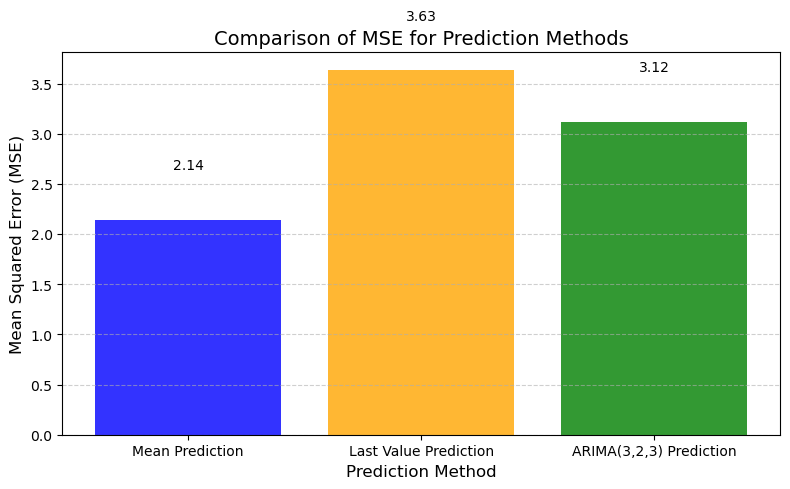

In [249]:
# Store in a list
mae_values = [mae_mean, mae_last, mae_os_test]

methods = ['Mean Prediction', 'Last Value Prediction', 'ARIMA(3,2,3) Prediction']

# Create the bar plot
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(methods, mae_values, color=['blue', 'orange', 'green'], alpha=0.8)

# Add value annotations on top of the bars
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval + 0.5, f'{yval:.2f}', ha='center', fontsize=10)

# Set labels and title
ax.set_xlabel('Prediction Method', fontsize=12)
ax.set_ylabel('Mean Squared Error (MSE)', fontsize=12)
ax.set_title('Comparison of MSE for Prediction Methods', fontsize=14)

# Add gridlines for better readability
ax.grid(axis='y', linestyle='--', alpha=0.6)

# Show the plot
plt.tight_layout()
plt.show()

 # 🔹 Step 7: Forecast Future Inflation - Next 24 Months

In [251]:
forecast_24Months = model_fit.forecast(steps=74)
forecast_24Months

441    0.433994
442    0.304518
443    0.089710
444   -0.006766
445   -0.006766
         ...   
510   -0.006766
511   -0.006766
512   -0.006766
513   -0.006766
514   -0.006766
Name: predicted_mean, Length: 74, dtype: float64

In [256]:

last_train_index = train.index[-1]  # Last date in training data

# Generate future timestamps for 17 quarters ahead
future_dates = pd.date_range(start=last_train_index, periods=75, freq='MS')[1:]  # Exclude last train date

# Convert forecasted values into a Pandas Series with the new index
forecast_series = pd.Series(forecast_24Months.values, index=future_dates)
forecast_series

1986-11-01    0.433994
1986-12-01    0.304518
1987-01-01    0.089710
1987-02-01   -0.006766
1987-03-01   -0.006766
                ...   
1992-08-01   -0.006766
1992-09-01   -0.006766
1992-10-01   -0.006766
1992-11-01   -0.006766
1992-12-01   -0.006766
Freq: MS, Length: 74, dtype: float64

In [260]:
# month=1
# # Initialize history from the train + test data (so that forecast can continue seamlessly)
# history = [x for x in train['inflation_1']] + [x for x in test['inflation_1']]

# # Initialize an empty list to store the inverted forecasted values
# inverted_forecasts = []

# # Loop for forecasting the next 7 days beyond the test set
# for _ in range(74):
#     # Use the model to predict the next step (forecast one step ahead)
#     yhat = model_fit.forecast(steps=1)  # Assuming the model is already fit and can forecast 1 step ahead
    
#     # Inverse the differencing to get the actual forecasted value
#     inverted = inverse_difference(history, yhat, 1)
    
#     # Print and append the forecasted value to the list
#     print('Month %d: %f' % (month, inverted))
#     inverted_forecasts.append(inverted)
    
#     # Append the inverted value to history to update it for the next forecast
#     history.append(inverted)
    
#     # Increment the day for the next forecast
#     month += 1


# Initialize an empty list to store the inverted forecasted values

inverted_forecasts = []
history = [x for x in train['inflation_1']]

# Loop over forecasted values and invert them
for yhat in forecast_mean_test['predicted_mean']:
    inverted = inverse_difference(history, yhat, 1)
    inverted_forecasts.append(inverted)
    history.append(inverted)


# print(f"Length of inverted_forecasts: {len(inverted_forecasts)}")
# print(f"Length of test index: {len(test.index)}")

# Convert to Pandas Series and align index with test data
inverted_forecasts = pd.Series(inverted_forecasts, index=test.index)


inverted_forecasts
   

date
1986-11-01    1.523703
1986-12-01    1.828220
1987-01-01    1.917931
1987-02-01    1.911165
1987-03-01    1.904399
1987-04-01    1.897634
1987-05-01    1.890868
1987-06-01    1.884102
1987-07-01    1.877337
1987-08-01    1.870571
1987-09-01    1.863806
1987-10-01    1.857040
1987-11-01    1.850274
1987-12-01    1.843509
1988-01-01    1.836743
1988-02-01    1.829977
1988-03-01    1.823212
1988-04-01    1.816446
1988-05-01    1.809681
1988-06-01    1.802915
1988-07-01    1.796149
1988-08-01    1.789384
1988-09-01    1.782618
1988-10-01    1.775853
1988-11-01    1.769087
1988-12-01    1.762321
1989-01-01    1.755556
1989-02-01    1.748790
1989-03-01    1.742024
1989-04-01    1.735259
1989-05-01    1.728493
1989-06-01    1.721728
1989-07-01    1.714962
1989-08-01    1.708196
1989-09-01    1.701431
1989-10-01    1.694665
1989-11-01    1.687899
1989-12-01    1.681134
1990-01-01    1.674368
1990-02-01    1.667603
1990-03-01    1.660837
1990-04-01    1.654071
1990-05-01    1.647306
1990-0

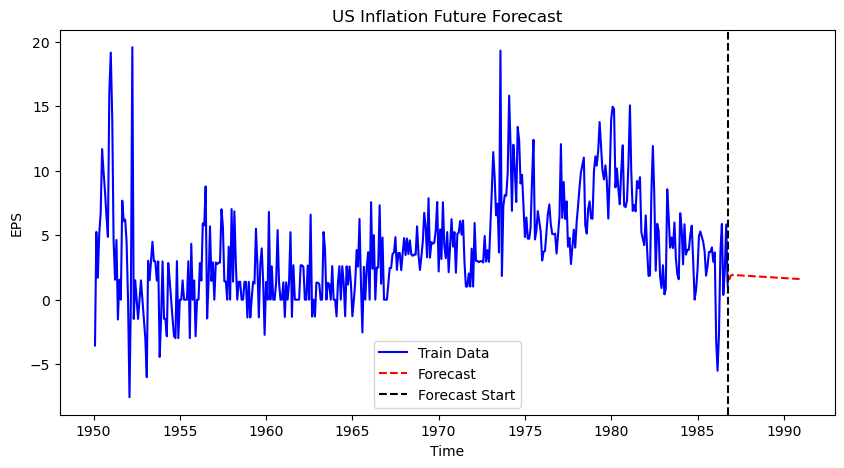

In [262]:
# Plot results
plt.figure(figsize=(10, 5))
plt.plot(train, label="Train Data", color='blue')
plt.plot(inverted_forecasts, label="Forecast", color='red', linestyle='dashed')
plt.axvline(x=last_train_index, color='black', linestyle='--', label="Forecast Start")
plt.legend()
plt.xlabel("Time")
plt.ylabel("EPS")
plt.title("US Inflation Future Forecast")
plt.show()

To forecast future values without including test data:

Use only your training data to train the model.
When making predictions for the future, use the model's forecasts iteratively, adding each prediction to the history for the next forecast.